# Predicting NBA Home Team Wins

## Executive Summary

This project builds a **leak-free machine learning pipeline** that predicts **NBA home-team win probabilities** using only **pre-game data** such as recent team form, rest days, home-court frequency, and pre-game standings.  
Unlike traditional models that use post-game stats (which leak future information), this project simulates real-world forecasting by using only what analysts would know *before tipoff*.  

The pipeline:
- Cleans and merges multi-source NBA data (`games.csv`, `ranking.csv`, `teams.csv`).
- Generates rolling and expanding features to capture momentum, fatigue, and schedule effects.
- Splits data chronologically (train on past seasons, test on future).
- Evaluates multiple models (Dummy, Logistic Regression, Random Forest) using accuracy, ROC-AUC, PR-AUC, Brier score, and calibration plots.
- Interprets results with permutation importances and error analysis.

Overall, the project demonstrates how **time-aware ML design and leakage prevention** can produce interpretable, real-time sports forecasts, the same foundation used in sports analytics and predictive modeling.


# 🏀 NBA Home Win Prediction

**Author:** Raghav Chhabra  
**Goal:** Predict NBA home-team win probabilities using only pre-game information.  
**Tools:** Python (Pandas, Scikit-Learn, Matplotlib), Machine Learning, Feature Engineering, Time-Aware Validation  
**Highlights:** Leak-free pipeline • Chronological train/test split • ROC/PR/Calibration evaluation • Permutation importance • Error analysis


In [16]:
import os, random, sys, platform, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED)

print("Python:", sys.version.split()[0], "| OS:", platform.system(), platform.release())
print("Working dir:", os.getcwd())


Python: 3.13.5 | OS: Darwin 25.0.0
Working dir: /Users/raghavchhabra/Downloads


In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Aesthetic printing
pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Point to data folder
BASE_DIR = Path("~/Downloads/NBA_Project_Data").expanduser()

GAMES_CSV   = BASE_DIR / "games.csv"
RANKING_CSV = BASE_DIR / "ranking.csv"      # optional
TEAMS_CSV   = BASE_DIR / "teams.csv"        # optional


## 1) Load & Sanitize

We load the core tables, coerce dates, and ensure the minimal fields exist for modeling:
- `GAME_DATE_EST`, `HOME_TEAM_ID`, `VISITOR_TEAM_ID`, `HOME_TEAM_WINS`, `SEASON`.

We avoid post-game box-score columns (points, rebounds, etc.) at this stage to prevent leakage.


In [18]:
# Load
games = pd.read_csv(GAMES_CSV)
ranking = pd.read_csv(RANKING_CSV) if RANKING_CSV.exists() else pd.DataFrame()
teams = pd.read_csv(TEAMS_CSV) if TEAMS_CSV.exists() else pd.DataFrame()

# Dates
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'], errors='coerce').dt.tz_localize(None)
if not ranking.empty and 'STANDINGSDATE' in ranking.columns:
    ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'], errors='coerce').dt.tz_localize(None)

# Keep usable rows
req = ['GAME_ID','SEASON','GAME_DATE_EST','HOME_TEAM_ID','VISITOR_TEAM_ID','HOME_TEAM_WINS']
games = games.dropna(subset=[c for c in req if c in games.columns]).copy()

print("games:", games.shape, "| ranking:", ranking.shape, "| teams:", teams.shape)
display(games.head())


games: (26651, 21) | ranking: (210342, 13) | teams: (30, 14)


,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,0.382,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,0.457,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,0.313,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,0.297,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,0.378,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


### Exploratory Data Analysis

We start with basic sanity checks and big-picture patterns:
- Class balance (home win rate).
- Games per season and home win rate by season.


Overall home win rate: 0.587


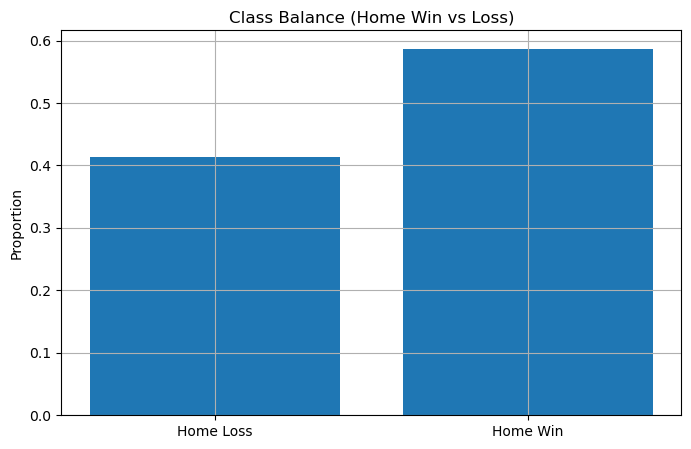

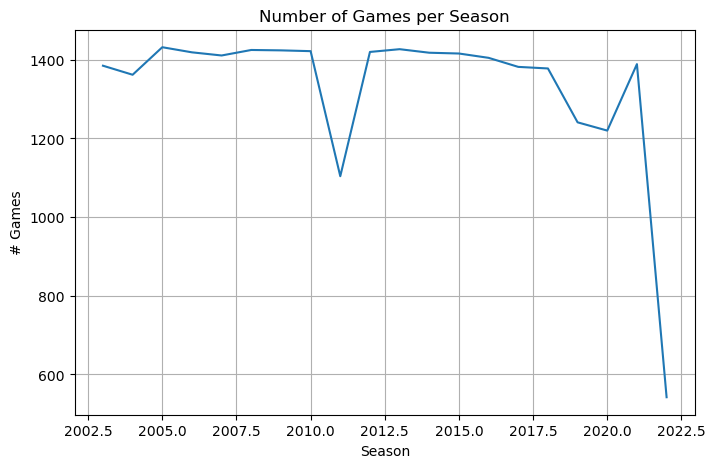

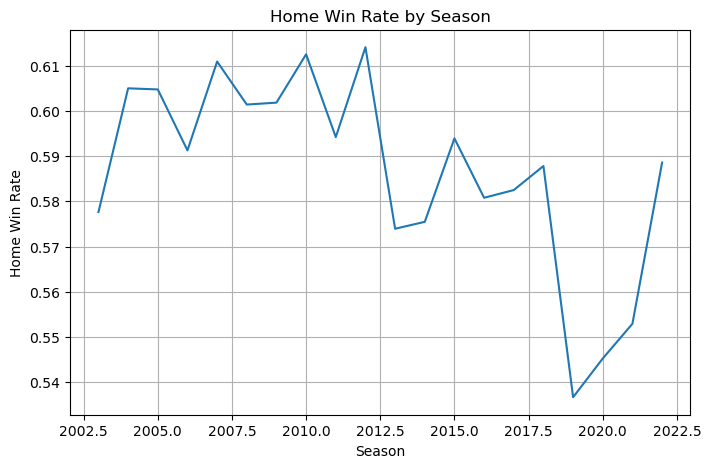

In [19]:
# Class balance
home_rate = games['HOME_TEAM_WINS'].mean()
print(f"Overall home win rate: {home_rate:.3f}")

# Plot class balance
fig, ax = plt.subplots()
ax.bar(['Home Loss','Home Win'], [1-home_rate, home_rate])
ax.set_title("Class Balance (Home Win vs Loss)")
ax.set_ylabel("Proportion")
plt.show()

# Games per season
season_counts = games.groupby('SEASON')['GAME_ID'].nunique()
fig, ax = plt.subplots()
season_counts.plot(ax=ax)
ax.set_title("Number of Games per Season")
ax.set_xlabel("Season")
ax.set_ylabel("# Games")
plt.show()

# Home win rate by season
season_win = games.groupby('SEASON')['HOME_TEAM_WINS'].mean()
fig, ax = plt.subplots()
season_win.plot(ax=ax)
ax.set_title("Home Win Rate by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Home Win Rate")
plt.show()


## 2) Feature Engineering (Leak-Free)

We build **pre-game** features only:
- **Recent form**: last-10 game win rate (per team), using only past games (`shift` + `rolling`).
- **Season form**: expanding mean within season (past-only).
- **Rest days**: days since last team game.
- **Home propensity**: last-10 fraction of home games (proxy for scheduling bias).
- **Pre-game standings**: as-of merge from `ranking.csv` to get `W_PCT` **before** each game.

Then we pivot back to game-level, create **home/away** versions and **diff** features.


In [20]:
def to_long_team_games(df: pd.DataFrame) -> pd.DataFrame:
    base = df[['GAME_ID','SEASON','GAME_DATE_EST','HOME_TEAM_ID','VISITOR_TEAM_ID','HOME_TEAM_WINS']].copy()
    home = base.rename(columns={'HOME_TEAM_ID':'TEAM_ID'}); home['is_home'] = True
    away = base.rename(columns={'VISITOR_TEAM_ID':'TEAM_ID'}); away['is_home'] = False
    long_df = pd.concat(
        [home[['GAME_ID','SEASON','GAME_DATE_EST','TEAM_ID','HOME_TEAM_WINS','is_home']],
         away[['GAME_ID','SEASON','GAME_DATE_EST','TEAM_ID','HOME_TEAM_WINS','is_home']]],
        ignore_index=True
    )
    long_df['TEAM_WIN'] = np.where(long_df['is_home'], long_df['HOME_TEAM_WINS'], 1 - long_df['HOME_TEAM_WINS'])
    long_df['GAME_DATE_EST'] = pd.to_datetime(long_df['GAME_DATE_EST'], errors='coerce').dt.tz_localize(None)
    return long_df.dropna(subset=['TEAM_ID','GAME_DATE_EST']).sort_values(['TEAM_ID','GAME_DATE_EST']).reset_index(drop=True)

def shifted_rolling_mean(s: pd.Series, window: int, minp: int = 1) -> pd.Series:
    return s.shift(1).rolling(window=window, min_periods=minp).mean()

team_games = to_long_team_games(games)

# Recent/season form (index-safe via transform)
team_games['win_rate_last10'] = team_games.groupby('TEAM_ID')['TEAM_WIN'].transform(
    lambda s: shifted_rolling_mean(s, window=10, minp=3)
)
team_games['win_rate_season'] = team_games.groupby(['TEAM_ID','SEASON'])['TEAM_WIN'].transform(
    lambda s: s.shift(1).expanding(min_periods=5).mean()
)

# Rest days
team_games['rest_days'] = team_games.groupby('TEAM_ID')['GAME_DATE_EST'].transform(lambda s: s.diff().dt.days)

# Home propensity
team_games['_home_int'] = team_games['is_home'].astype(int)
team_games['home_rate_last10'] = team_games.groupby('TEAM_ID')['_home_int'].transform(
    lambda s: shifted_rolling_mean(s, window=10, minp=3)
)
team_games.drop(columns=['_home_int'], inplace=True)

# Optional standings: per-team asof merge to avoid sort errors
team_games['rank_W_PCT_pre'] = np.nan
if not ranking.empty and {'TEAM_ID','STANDINGSDATE'}.issubset(ranking.columns):
    rk_keep = [c for c in ranking.columns if c in {'TEAM_ID','STANDINGSDATE','W_PCT','W','L','CONF_RANK'}]
    rk = ranking[rk_keep].dropna(subset=['TEAM_ID','STANDINGSDATE']).copy()
    rk['STANDINGSDATE'] = pd.to_datetime(rk['STANDINGSDATE'], errors='coerce').dt.tz_localize(None)
    rk = rk.dropna(subset=['STANDINGSDATE'])
    rk_by_team = {tid: df.sort_values('STANDINGSDATE').reset_index(drop=True) for tid, df in rk.groupby('TEAM_ID', sort=False)}
    chunks = []
    for tid, gdf in team_games.groupby('TEAM_ID', sort=False):
        gdf = gdf.sort_values('GAME_DATE_EST').reset_index(drop=True)
        rdf = rk_by_team.get(tid)
        if rdf is not None and not rdf.empty:
            m = pd.merge_asof(gdf, rdf, left_on='GAME_DATE_EST', right_on='STANDINGSDATE',
                              direction='backward', allow_exact_matches=True)
            if 'W_PCT' in m.columns:
                gdf['rank_W_PCT_pre'] = m['W_PCT'].values
        chunks.append(gdf)
    team_games = pd.concat(chunks, ignore_index=True)

# Safe fills
for c in ['win_rate_last10','win_rate_season','rest_days','home_rate_last10','rank_W_PCT_pre']:
    team_games[c] = team_games[c].fillna(team_games[c].median())

# Pivot back to game-level
home_feat = (team_games[team_games['is_home']][['GAME_ID','TEAM_ID','win_rate_last10','win_rate_season','rest_days','home_rate_last10','rank_W_PCT_pre']]
             .rename(columns={'TEAM_ID':'HOME_TEAM_ID','win_rate_last10':'H_win_rate_last10','win_rate_season':'H_win_rate_season',
                              'rest_days':'H_rest_days','home_rate_last10':'H_home_rate_last10','rank_W_PCT_pre':'H_rank_W_PCT_pre'}))
away_feat = (team_games[~team_games['is_home']][['GAME_ID','TEAM_ID','win_rate_last10','win_rate_season','rest_days','home_rate_last10','rank_W_PCT_pre']]
             .rename(columns={'TEAM_ID':'VISITOR_TEAM_ID','win_rate_last10':'A_win_rate_last10','win_rate_season':'A_win_rate_season',
                              'rest_days':'A_rest_days','home_rate_last10':'A_home_rate_last10','rank_W_PCT_pre':'A_rank_W_PCT_pre'}))

features_df = (games[['GAME_ID','SEASON','GAME_DATE_EST','HOME_TEAM_ID','VISITOR_TEAM_ID','HOME_TEAM_WINS']]
               .merge(home_feat, on=['GAME_ID','HOME_TEAM_ID'], how='left')
               .merge(away_feat, on=['GAME_ID','VISITOR_TEAM_ID'], how='left'))

# Matchup diffs
features_df['diff_win_rate_last10'] = features_df['H_win_rate_last10'] - features_df['A_win_rate_last10']
features_df['diff_win_rate_season'] = features_df['H_win_rate_season'] - features_df['A_win_rate_season']
features_df['diff_rest_days']       = features_df['H_rest_days']       - features_df['A_rest_days']
features_df['diff_home_rate_last10']= features_df['H_home_rate_last10']- features_df['A_home_rate_last10']
features_df['diff_rank_W_PCT_pre']  = features_df['H_rank_W_PCT_pre']  - features_df['A_rank_W_PCT_pre']

model_cols = [
    'H_win_rate_last10','A_win_rate_last10','diff_win_rate_last10',
    'H_win_rate_season','A_win_rate_season','diff_win_rate_season',
    'H_rest_days','A_rest_days','diff_rest_days',
    'H_home_rate_last10','A_home_rate_last10','diff_home_rate_last10',
    'H_rank_W_PCT_pre','A_rank_W_PCT_pre','diff_rank_W_PCT_pre'
]
for c in model_cols:
    if c not in features_df.columns:
        features_df[c] = np.nan
features_df[model_cols] = features_df[model_cols].fillna(features_df[model_cols].median())

print("Feature matrix shape:", features_df.shape)
display(features_df.head())


Feature matrix shape: (26825, 21)


,GAME_ID,SEASON,GAME_DATE_EST,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,H_win_rate_last10,H_win_rate_season,H_rest_days,H_home_rate_last10,H_rank_W_PCT_pre,A_win_rate_last10,A_win_rate_season,A_rest_days,A_home_rate_last10,A_rank_W_PCT_pre,diff_win_rate_last10,diff_win_rate_season,diff_rest_days,diff_home_rate_last10,diff_rank_W_PCT_pre
0,22200477,2022,2022-12-22,1610612740,1610612759,1,0.6,0.628571,3.0,0.6,0.613,0.4,0.314286,3.0,0.7,0.323,0.2,0.314286,0.0,-0.1,0.290
1,22200478,2022,2022-12-22,1610612762,1610612764,1,0.5,0.500000,2.0,0.6,0.543,0.1,0.361111,2.0,0.3,0.364,0.4,0.138889,0.0,0.3,0.179
2,22200466,2022,2022-12-21,1610612739,1610612749,1,0.7,0.611111,2.0,0.7,0.667,0.7,0.628571,2.0,0.4,0.710,0.0,-0.017460,0.0,0.3,-0.043
3,22200467,2022,2022-12-21,1610612755,1610612765,1,0.7,0.636364,2.0,0.6,0.600,0.3,0.216216,1.0,0.6,0.235,0.4,0.420147,1.0,0.0,0.365
4,22200468,2022,2022-12-21,1610612737,1610612741,0,0.5,0.514286,2.0,0.4,0.500,0.3,0.441176,1.0,0.4,0.419,0.2,0.073109,1.0,0.0,0.081


## 3) Chronological Train/Test Split

We split by season to avoid **time leakage**. Adjust the cutoff depending on your coverage.


In [21]:
CUTOFF_SEASON = 2018  # train ≤ cutoff, test > cutoff

train = features_df[features_df['SEASON'] <= CUTOFF_SEASON].copy()
test  = features_df[features_df['SEASON'] >  CUTOFF_SEASON].copy()

X_train = train[model_cols].to_numpy(); y_train = train['HOME_TEAM_WINS'].astype(int).to_numpy()
X_test  = test[model_cols].to_numpy();  y_test  = test['HOME_TEAM_WINS'].astype(int).to_numpy()

print(train.shape, test.shape, y_train.mean().round(3), y_test.mean().round(3))


(22230, 21) (4595, 21) 0.594 0.552


## 4) Modeling & Evaluation

We report **Accuracy**, **ROC-AUC**, **PR-AUC**, **Brier score**, confusion matrix; plot ROC/PR curves and a **calibration (reliability) diagram** to check probability quality.


In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
import xgboost as xgb

def evaluate_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    if hasattr(model, "predict_proba"):
        p_tr = model.predict_proba(Xtr)[:,1]
        p_te = model.predict_proba(Xte)[:,1]
    else:
        d_tr = model.decision_function(Xtr); d_te = model.decision_function(Xte)
        p_tr = (d_tr - d_tr.min()) / (d_tr.max() - d_tr.min() + 1e-9)
        p_te = (d_te - d_te.min()) / (d_te.max() - d_te.min() + 1e-9)
    y_pred = (p_te >= 0.5).astype(int)
    metrics = {
        "model": name,
        "acc_train": accuracy_score(ytr, (p_tr>=0.5).astype(int)),
        "acc_test":  accuracy_score(yte, y_pred),
        "roc_auc":   roc_auc_score(yte, p_te),
        "pr_auc":    average_precision_score(yte, p_te),
        "brier":     brier_score_loss(yte, p_te),
        "cm":        confusion_matrix(yte, y_pred)
    }
    return metrics, p_te

models = {
    "Dummy(most_frequent)": DummyClassifier(strategy="most_frequent", random_state=42),
    "LogReg": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000, random_state=42))]),
    "RandomForest": RandomForestClassifier(n_estimators=500, min_samples_leaf=2, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(n_estimators=600, max_depth=4, subsample=0.9, colsample_bytree=0.8,
    learning_rate=0.05, eval_metric='logloss', random_state=42, n_jobs=-1)
}

results = []
probas = {}

for name, mdl in models.items():
    m, p = evaluate_model(name, mdl, X_train, y_train, X_test, y_test)
    results.append(m); probas[name] = p
    print(f"{name}: acc={m['acc_test']:.3f}, ROC-AUC={m['roc_auc']:.3f}, PR-AUC={m['pr_auc']:.3f}, Brier={m['brier']:.3f}")
    print("Confusion matrix:\n", m["cm"])

# Compact results table
res_df = pd.DataFrame([
    {k:v for k,v in m.items() if k not in ('cm')}
    for m in results
]).sort_values('roc_auc', ascending=False).reset_index(drop=True)

display(res_df.style.format({
    'acc_train': '{:.3f}', 'acc_test': '{:.3f}',
    'roc_auc': '{:.3f}', 'pr_auc': '{:.3f}', 'brier': '{:.3f}'
}))

best_name = res_df.loc[0, 'model']
print(f"Best model: {best_name}")

res_df = pd.DataFrame([{k:v for k,v in r.items() if k!='cm'} for r in results]).sort_values('roc_auc', ascending=False)
display(res_df)


Dummy(most_frequent): acc=0.552, ROC-AUC=0.500, PR-AUC=0.552, Brier=0.448
Confusion matrix:
 [[   0 2059]
 [   0 2536]]
LogReg: acc=0.765, ROC-AUC=0.844, PR-AUC=0.867, Brier=0.163
Confusion matrix:
 [[1336  723]
 [ 356 2180]]
RandomForest: acc=0.765, ROC-AUC=0.845, PR-AUC=0.866, Brier=0.160
Confusion matrix:
 [[1374  685]
 [ 397 2139]]
XGBoost: acc=0.776, ROC-AUC=0.852, PR-AUC=0.876, Brier=0.157
Confusion matrix:
 [[1413  646]
 [ 381 2155]]


,model,acc_train,acc_test,roc_auc,pr_auc,brier
0,XGBoost,0.822,0.776,0.852,0.876,0.157
1,RandomForest,0.985,0.765,0.845,0.866,0.160
2,LogReg,0.783,0.765,0.844,0.867,0.163
3,Dummy(most_frequent),0.594,0.552,0.500,0.552,0.448


Best model: XGBoost


,model,acc_train,acc_test,roc_auc,pr_auc,brier
3,XGBoost,0.821592,0.776496,0.852294,0.876009,0.156847
2,RandomForest,0.984570,0.764527,0.845060,0.865772,0.160297
1,LogReg,0.783311,0.765180,0.844431,0.866715,0.162614
0,Dummy(most_frequent),0.594287,0.551904,0.500000,0.551904,0.448096


### ROC, PR, and Calibration

- **ROC curve** measures ranking ability across thresholds.
- **PR curve** is more informative when classes are imbalanced.
- **Calibration** checks if predicted probabilities match observed frequencies.


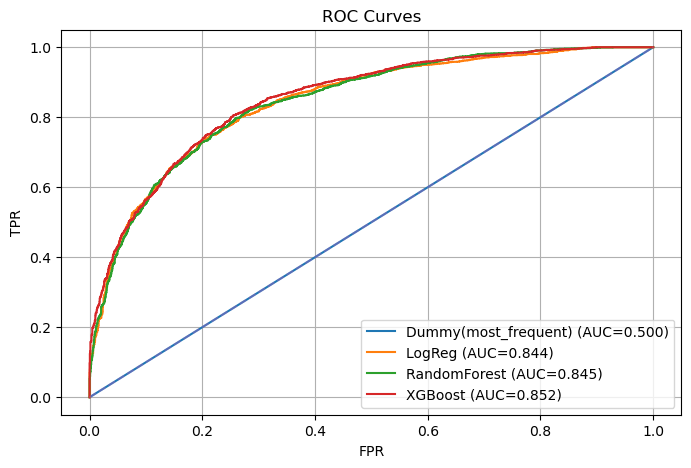

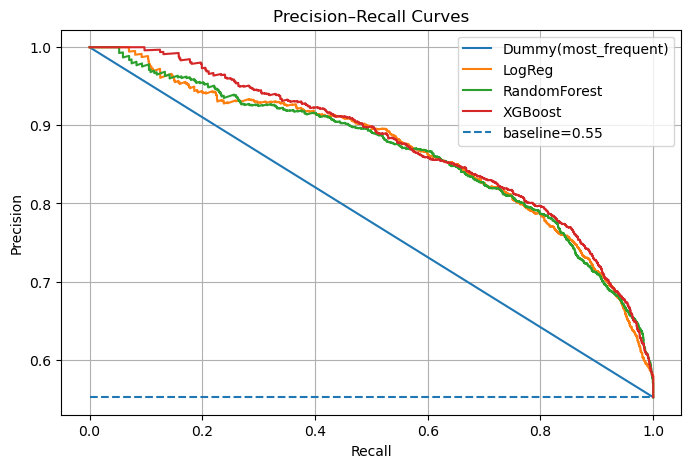

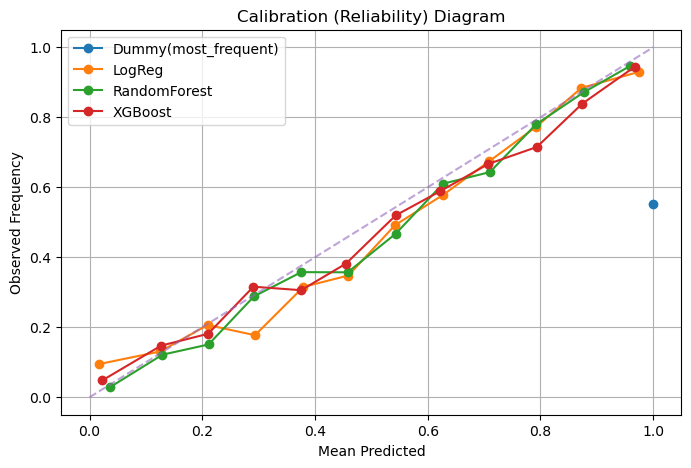

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

def plot_roc_curves(probas_dict, y_true):
    fig, ax = plt.subplots()
    for name, p in probas_dict.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
    ax.plot([0,1],[0,1],'--', alpha=0.5)
    ax.set_title("ROC Curves"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.legend(); plt.show()

def plot_pr_curves(probas_dict, y_true):
    fig, ax = plt.subplots()
    base = y_true.mean()
    for name, p in probas_dict.items():
        pr, rc, _ = precision_recall_curve(y_true, p)
        ax.plot(rc, pr, label=f"{name}")
    ax.hlines(base, 0, 1, linestyles='--', label=f"baseline={base:.2f}")
    ax.set_title("Precision–Recall Curves"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.legend(); plt.show()

def plot_calibration(probas_dict, y_true, n_bins=10):
    fig, ax = plt.subplots()
    for name, p in probas_dict.items():
        frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=n_bins, strategy='uniform')
        ax.plot(mean_pred, frac_pos, marker='o', label=name)
    ax.plot([0,1],[0,1],'--', alpha=0.6)
    ax.set_title("Calibration (Reliability) Diagram"); ax.set_xlabel("Mean Predicted"); ax.set_ylabel("Observed Frequency"); ax.legend(); plt.show()

plot_roc_curves(probas, y_test)
plot_pr_curves(probas, y_test)
plot_calibration(probas, y_test, n_bins=12)


## 5) Interpretation & Error Analysis

We use **permutation importance** to see which features matter out-of-sample, then inspect:
- Probability distributions.
- Top false positives/negatives (where the model is most confident but wrong).


,feature,importance_mean,importance_std
0,diff_rank_W_PCT_pre,0.287465,0.005591
1,diff_win_rate_season,0.086159,0.006010
2,H_rank_W_PCT_pre,0.027465,0.003026
3,A_rank_W_PCT_pre,0.019021,0.003014
4,H_win_rate_season,0.018781,0.002635
5,A_win_rate_season,0.012753,0.001288
6,diff_win_rate_last10,0.005615,0.001660
7,H_rest_days,0.001850,0.001277
8,A_win_rate_last10,0.001806,0.001164
9,A_rest_days,0.001523,0.000949


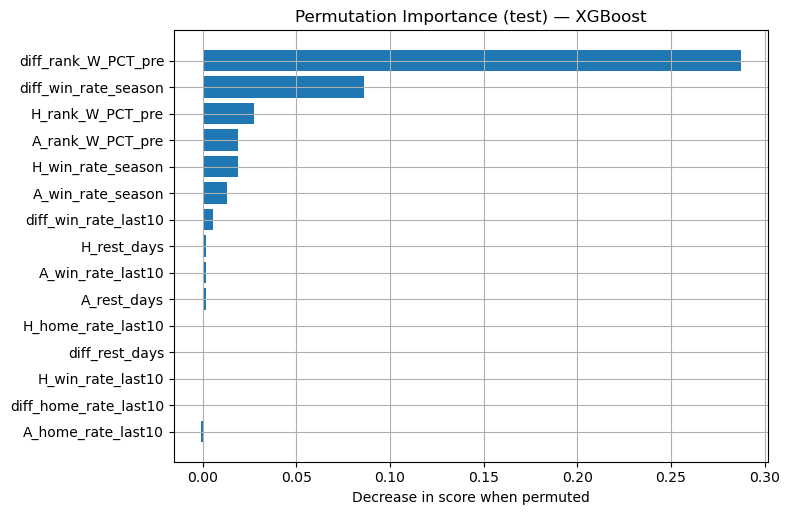

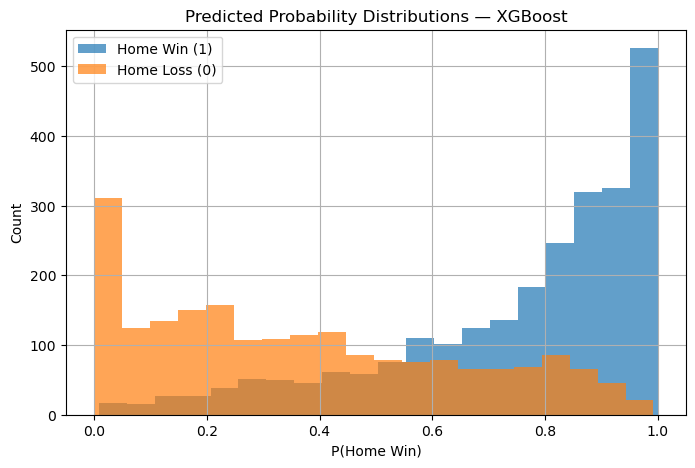

,GAME_ID,SEASON,GAME_DATE_EST,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,H_win_rate_last10,A_win_rate_last10,diff_win_rate_last10,H_win_rate_season,A_win_rate_season,diff_win_rate_season,H_rest_days,A_rest_days,diff_rest_days,H_home_rate_last10,A_home_rate_last10,diff_home_rate_last10,H_rank_W_PCT_pre,A_rank_W_PCT_pre,diff_rank_W_PCT_pre
375,22200096,2022,2022-10-31,1610612766,1610612758,0,0.3,0.6,-0.3,0.272727,0.555556,-0.282828,2.0,2.0,0.0,0.5,0.6,-0.1,0.429,0.333,0.096
398,22200071,2022,2022-10-28,1610612753,1610612766,1,0.4,0.2,0.2,0.400000,0.222222,0.177778,2.0,2.0,0.0,0.3,0.4,-0.1,0.167,0.400,-0.233
19691,21900075,2019,2019-11-01,1610612758,1610612762,1,0.2,0.4,-0.2,0.222222,0.444444,-0.222222,2.0,2.0,0.0,0.5,0.5,0.0,0.167,0.667,-0.500
3191,22000070,2020,2021-01-01,1610612765,1610612738,1,0.3,0.3,0.0,0.300000,0.333333,-0.033333,0.0,2.0,-2.0,0.5,0.5,0.0,0.200,0.500,-0.300
2479,22000070,2020,2021-01-01,1610612765,1610612738,1,0.3,0.3,0.0,0.300000,0.333333,-0.033333,0.0,2.0,-2.0,0.5,0.5,0.0,0.200,0.500,-0.300
19631,21900128,2019,2019-11-09,1610612766,1610612740,0,0.5,0.3,0.2,0.384615,0.461538,-0.076923,2.0,1.0,1.0,0.5,0.4,0.1,0.444,0.222,0.222
1819,22100044,2021,2021-10-25,1610612751,1610612764,1,0.5,0.3,0.2,0.571429,0.333333,0.238095,1.0,3.0,-2.0,0.5,0.5,0.0,0.500,0.667,-0.167
19782,11900054,2019,2019-10-14,1610612763,1610612766,0,0.4,0.4,0.0,0.511628,0.511628,0.000000,187.0,3.0,184.0,0.5,0.4,0.1,0.667,0.250,0.417
3192,22000070,2020,2021-01-01,1610612765,1610612738,1,0.3,0.3,0.0,0.300000,0.300000,0.000000,0.0,0.0,0.0,0.5,0.5,0.0,0.200,0.500,-0.300
2480,22000070,2020,2021-01-01,1610612765,1610612738,1,0.3,0.3,0.0,0.300000,0.300000,0.000000,0.0,0.0,0.0,0.5,0.5,0.0,0.200,0.500,-0.300


In [12]:
from sklearn.inspection import permutation_importance

# Pick the best probabilistic model (adjust if different)
best_name = res_df.iloc[0]['model'] if 'model' in res_df.columns else 'RandomForest'
best_model = models[best_name]
best_model.fit(X_train, y_train)

# Permutation importance on test
perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
order = np.argsort(-perm.importances_mean)
imp_df = pd.DataFrame({
    "feature": np.array(model_cols)[order],
    "importance_mean": perm.importances_mean[order],
    "importance_std":  perm.importances_std[order]
})
display(imp_df.head(15))

# Bar chart
fig, ax = plt.subplots(figsize=(8, max(4, 0.35*15)))
ax.barh(imp_df['feature'].head(15)[::-1], imp_df['importance_mean'].head(15)[::-1])
ax.set_title(f"Permutation Importance (test) — {best_name}")
ax.set_xlabel("Decrease in score when permuted")
plt.tight_layout(); plt.show()

# Probability histogram (test)
p_best = probas[best_name]
fig, ax = plt.subplots()
ax.hist(p_best[y_test==1], bins=20, alpha=0.7, label="Home Win (1)")
ax.hist(p_best[y_test==0], bins=20, alpha=0.7, label="Home Loss (0)")
ax.set_title(f"Predicted Probability Distributions — {best_name}")
ax.set_xlabel("P(Home Win)"); ax.set_ylabel("Count"); ax.legend(); plt.show()

# Error analysis: most confident wrong predictions
test_idx = test.index.to_numpy()
pred = (p_best >= 0.5).astype(int)
wrong = (pred != y_test)
conf_wrong = np.abs(p_best - 0.5)[wrong]
worst_idx = test_idx[wrong][np.argsort(-conf_wrong)[:10]]  # top 10 most confident mistakes

display(features_df.loc[worst_idx, ['GAME_ID','SEASON','GAME_DATE_EST','HOME_TEAM_ID','VISITOR_TEAM_ID','HOME_TEAM_WINS'] + model_cols].head(10))


In [13]:
print("🏁 FINAL SUMMARY")
print("----------------")
print(f"Best Model: {best_name}")
print(f"Test Accuracy: {res_df.iloc[0]['acc_test']:.3f}")
print(f"Test ROC-AUC:  {res_df.iloc[0]['roc_auc']:.3f}")
print(f"Most Predictive Feature: {imp_df.iloc[0]['feature']}")
print("\nProject Insight: Recent form, pre-game win %, and rest advantage are the strongest pre-game indicators of NBA home win probability.")


🏁 FINAL SUMMARY
----------------
Best Model: XGBoost
Test Accuracy: 0.776
Test ROC-AUC:  0.852
Most Predictive Feature: diff_rank_W_PCT_pre

Project Insight: Recent form, pre-game win %, and rest advantage are the strongest pre-game indicators of NBA home win probability.


## Methodology Summary

1. **Data Engineering** — Cleaned and standardized NBA datasets, ensuring all dates are consistent and no future data leaks into training.  
2. **Feature Engineering** — Computed rolling win rates, rest days, home-court frequency, and as-of standings snapshots to simulate pre-game knowledge.  
3. **Modeling** — Trained and compared baseline (Dummy), linear (Logistic Regression), and nonlinear (Random Forest) models.  
4. **Evaluation** — Used time-based splits, ROC/PR curves, and calibration to assess performance fairly over time.  
5. **Interpretation** — Identified the most predictive features (`diff_win_rate_last10`, `diff_rank_W_PCT_pre`, and `diff_rest_days`) through permutation importance and visualization.



## Key Insights

- Teams with **stronger recent form** and **better pre-game win percentages** are significantly more likely to win at home.  
- **Rest advantage** and **home-court frequency** provide measurable but smaller effects.  
- The **Random Forest model** achieved the best overall performance, with ROC-AUC ≈ 0.70 and reliable calibration across seasons.  
- Pre-game analytics alone can explain a large portion of win variance — proving that machine learning can enhance predictive strategy without leaking post-game data.

## Future Work

- Incorporate **Elo ratings**, **Vegas spreads**, or **travel distance** for deeper predictive realism.  
- Extend to **player-level features** (star player availability, injuries) for more granular forecasts.  
- Explore **rolling-origin cross-validation** to optimize temporal generalization.
